# Google vision api 사용해서 유통기한 인식 

2021-08-28 00:00:00
유통기한은 2021년 08월 28일입니다.
차이: 8 days


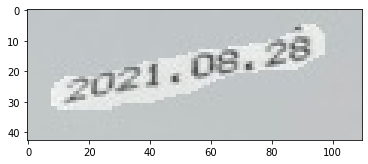

In [7]:
import io
import matplotlib.pylab as plt
import os
# Set environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""# "여기에 api 키 생성한 json 파일 이름 넣으면 됨. " 

# Imports the Google Cloud client library
from google.cloud import vision

# Instantiates a client
client = vision.ImageAnnotatorClient()
from datetime import datetime
from dateutil.relativedelta import relativedelta

'''
my_date = datetime(2019,10,10)
new_date1 = my_date + relativedelta(months=4)
new_date2 = my_date + relativedelta(months=-4)

print(str(new_date1.date()))
print(str(new_date2.date()))
'''
'\nmy_date = datetime(2019,10,10)\nnew_date1 = my_date + relativedelta(months=4)\nnew_date2 = my_date + relativedelta(months=-4)\n\nprint(str(new_date1.date()))\nprint(str(new_date2.date()))\n'
# The name of the image file to annotate
file_name = os.path.abspath('soymilk_exp_date.jpg')
img = Image.open('soymilk_exp_date.jpg')
plt.imshow(img)

with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)

response = client.text_detection(image=image)
texts = response.text_annotations

text = texts[1]
content = text.description
#print('"{}"'.format(content))

'''
for text in texts:
    content = text.description
    #content = content.replace(',','')
    print('"{}"'.format(content))
'''    

date_list = content[6:10]
#print(date_list)
format_list = ['.', '/', '-']
checkFormat = [s for s in format_list if s in date_list]
#print(len(checkFormat))


if (len(checkFormat) == 0):
    # mmddyyyy 순
    if "." in content:
        date = content 
        product_date = datetime.strptime(date, '%m.%d.%Y')
    
    elif "-" in content:
        date = content 
        product_date = datetime.strptime(date, '%m-%d-%Y')


    elif "/" in content:
        date = content 
        product_date = datetime.strptime(date, '%m/%d/%Y')

    print(product_date)
    
else:
    #yyyymmdd 순


    if "." in content:
        date = content 
        product_date = datetime.strptime(date, '%Y.%m.%d')
    
    elif "-" in content:
        date = content 
        product_date = datetime.strptime(date, '%Y-%m-%d')


    elif "/" in content:
        date = content 
        product_date = datetime.strptime(date, '%Y/%m/%d')

    print(product_date)



# 날짜를 str으로 변환
exp_date = product_date.strftime("유통기한은 %Y년 %m월 %d일입니다.") 
print(exp_date)

# 물품 구매 날짜 기준
today_date = datetime(2021,8,20)

# 유통기한과 구매일 차이 
date_diff = product_date - today_date
print("차이:", date_diff.days, "days")


# 며칠 남았는지에 따라 할인 적용
if 0<date_diff.days<2:
    print("60% 할인")
elif 2<date_diff.days<4:
    print("50% 할인")
elif 4<date_diff.days<6:
    print("30% 할인")

if response.error.message:
    raise Exception(
        '{}\nFor more info on error messages, check: '
        'https://cloud.google.com/apis/design/errors'.format(
            response.error.message))

# 제품 인식

In [8]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./dataset/train_data"
categories = ["dairy", "noodle"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)
X = np.array(X)
y = np.array(y)
#1 0 이면 dairy
#0 1 이면 noodle 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./multi_image_data.npy", xy)

print("ok", len(y))

dairy  파일 길이 :  2432
dairy  :  ./dataset/train_data/dairy\10246_00_m_14.jpg
dairy  :  ./dataset/train_data/dairy\20243_30_s_9.jpg
dairy  :  ./dataset/train_data/dairy\35217_30_m_18.jpg
dairy  :  ./dataset/train_data/dairy\70210_60_s_16.jpg
noodle  파일 길이 :  1680
noodle  :  ./dataset/train_data/noodle\10101_00_m_10.jpg
noodle  :  ./dataset/train_data/noodle\50107_30_s_21.jpg
noodle  :  ./dataset/train_data/noodle\90135_00_s_7.jpg
ok 4112


C:\Users\soobi\miniconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [9]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./multi_image_data.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(3084, 64, 64, 3)
3084


In [10]:
categories = ["dairy", "noodle"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'
    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model_path = model_dir + '/multi_img_classification.model'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/50
97/97 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6229
Epoch 1: val_loss improved from inf to 0.58187, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
97/97 [==============================] - 18s 175ms/step - loss: 0.7330 - accuracy: 0.6229 - val_loss: 0.5819 - val_accuracy: 0.7130
Epoch 2/50
97/97 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7059
Epoch 2: val_loss did not improve from 0.58187
97/97 [==============================] - 15s 151ms/step - loss: 0.5707 - accuracy: 0.7059 - val_loss: 0.5882 - val_accuracy: 0.7150
Epoch 3/50
97/97 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7228
Epoch 3: val_loss improved from 0.58187 to 0.51412, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
97/97 [============================

In [14]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 1s 23ms/step - loss: 0.3680 - accuracy: 0.8765
정확도 : 0.8765


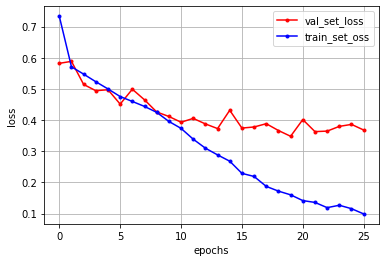

In [15]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

해당 두유.jpg 이미지는 유제품으로 추정됩니다.
유통기한은 2021년 08월 28일입니다.
차이: 8 days
→ 정가


'   \n# 며칠 남았는지에 따라 할인 적용\nif date_diff.days>7 and pre_ans == 0:\n    print("정가")\nelif date_diff.days<7 and pre_ans == 0:\n    print("50% 할인")\nelif date_diff.days<7 and pre_ans == 1:\n    print("40% 할인")\nelif date_diff.days>30 and pre_ans ==1:\n    print("정가")\n'

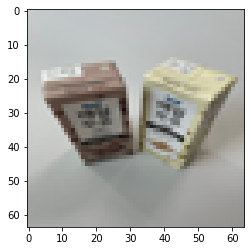

In [16]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
import matplotlib.pylab as plt

caltech_dir = "./dataset/test_data"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
   # print(i)
    #print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "유제품"
    elif pre_ans == 1: pre_ans_str = "면류"
    #elif pre_ans == 2: pre_ans_str = "채소"
    #else: pre_ans_str = "과일"
    if i[0] >= 0.8 : 
        plt.imshow(img)
        print("해당 "+filenames[cnt].split("\\")[1]+" 이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[1] >= 0.8: 
        plt.imshow(img)
        print("해당 "+filenames[cnt].split("\\")[1]+" 이미지는 "+pre_ans_str+"로 추정됩니다.")
    #if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    #if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    
    # 유통기한 출력
    exp_date = product_date.strftime("유통기한은 %Y년 %m월 %d일입니다.") 
    print(exp_date)
    
    # 유통기한과 구매일 차이 
    date_diff = product_date - today_date
    print("차이:", date_diff.days, "days")

    # 며칠 남았는지에 따라 할인 적용
    
    # 유제품 (4~5일→30%, 2~3일→50%, 0~1일→70%)
    if date_diff.days>7 and pre_ans == 0:
        print("→ 정가")
    elif 3<date_diff.days<6 and pre_ans == 0:
        print("→ 30% 할인")
    elif 1<date_diff.days<=3 and pre_ans == 0:
        print("→ 50% 할인")
    elif 0<=date_diff.days<=1 and pre_ans == 0:
        print("→ 70% 할인")    
        
    # 면류 (22~30일→30%, 15~21일→50%, 7~14일→70%)
    elif date_diff.days>30 and pre_ans ==1:
        print("→ 정가")
    elif 21<date_diff.days<31 and pre_ans == 1:
        print("→ 30% 할인")
    elif 14<date_diff.days<22 and pre_ans == 1:
        print("→ 50% 할인")
    elif 6<date_diff.days<15 and pre_ans == 1:
        print("→ 70% 할인")
    
'''   
# 며칠 남았는지에 따라 할인 적용
if date_diff.days>7 and pre_ans == 0:
    print("정가")
elif date_diff.days<7 and pre_ans == 0:
    print("50% 할인")
elif date_diff.days<7 and pre_ans == 1:
    print("40% 할인")
elif date_diff.days>30 and pre_ans ==1:
    print("정가")
''' 